In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import requests
import os
from PIL import Image


%matplotlib inline

In [ ]:
url_clickbait = 'https://raw.githubusercontent.com/Filip1402/YoutubeClickbaitDetector/main/dataset2/clickbait.csv'
url_not_clickbait = 'https://raw.githubusercontent.com/Filip1402/YoutubeClickbaitDetector/main/dataset2/notClickbait.csv'

my_df_clickbait = pd.read_csv(url_clickbait)
#my_df_clickbait.insert(6,'Clickbait',value=1,allow_duplicates=True)
my_df_not_clickbait = pd.read_csv(url_not_clickbait)
#my_df_not_clickbait.insert(6,'Clickbait',value=0,allow_duplicates=True)
my_df  = pd.concat([my_df_clickbait, my_df_not_clickbait], ignore_index=True)


In [ ]:
my_df

,ID,Video Title,Description,Views,Likes,Dislikes,Comment Count,clickbait
0,vS_EjQ5RcjM,Jojo Siwa's plane is going down goodbye..,Jojo Siwa's plane is going down goodbye.. Tod...,40586,1966.0,9,41.0,1
1,-fMdjf4yG1M,6 Youtubers Who Got HACKED LIVE.. (Jojo Siwa ...,6 Youtubers Who Got HACKED LIVE.. (Jojo Siwa ...,6072,314.0,6,23.0,1
2,-AuYhwTHK9k,SSundee forgot to stop recording.. (VERY SAD),SSundee forgot to stop recording.. (VERY SAD)....,869597,16443.0,25964,762.0,1
3,4YZSr2J45TU,What SSSniperWolf Is Like IN REAL LIFE.. (VERY...,What SSSniperWolf Is Like IN REAL LIFE.. (VERY...,36921,1300.0,1020,358.0,1
4,9psUAeAtIbg,7 YouTubers Who Got SENT TO JAIL! (Brianna Pr...,7 YouTubers Who Got SENT TO JAIL! (Brianna Pr...,9027,364.0,6,6.0,1
...,...,...,...,...,...,...,...,...
1595,FeXJRMbRt0I,Setting Up The Django Admin Area - Build An AP...,Whenever you start a new Django Project one o...,5069,70.0,4,10.0,0
1596,s3trxPS3ggI,Fizzbuzz With Python - #20,How to create Fizzbuzz with Python. In this vi...,5527,156.0,2,15.0,0
1597,2G9-H3ccOMY,My Python Book Is Out!! - Codemy.com,The book is out!! Intro To Python: Beginners...,3109,198.0,3,53.0,0
1598,p7MkQHfVbcQ,First Flutter App On Android - Build Flutter A...,In this video we'll set up an Android Emulator...,51285,1154.0,23,59.0,0


In [ ]:
# Define the output folder
output_folder = "Thumbnails"
os.makedirs(output_folder, exist_ok=True)

# GitHub repository URL
github_repo_url = "https://github.com/Filip1402/YoutubeClickbaitDetector/blob/main/dataset2/thumbnails/"

# Function to download image
def download_image(url, file_path):
    try:
        url+='?raw=true'
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        return True
    except Exception as e:
        print(f"Failed to download ({index}/{len(my_df)}): {url} - {e}")
        return False

# Iterate through DataFrame
failure_count = 0
for index, row in my_df.iterrows():
    file_name = row['ID']

    file_path = os.path.join(output_folder, f"{file_name}.jpg")
    if os.path.exists(file_path):
        print(f"Image ({index}/{len(my_df)}) already exists: {file_name}")
    else:
        url = github_repo_url + file_name + '.jpg'
        success = download_image(url, file_path)
        if success:
            print(f"Downloaded ({index}/{len(my_df)}): {file_name}")
        else:
            failure_count+=1
print(f'{failure_count}  thumbnails failed to be download!')

!rm -rf Thumbnails/

In [ ]:
X = []
y= my_df['clickbait'].tolist()
def read_images_to_tensors(folder_path, image_size=(224, 224)):

    # Get list of image file names
    image_files = [file_name + '.jpg' for file_name in my_df['ID'].tolist()]

    # Initialize empty list to store image tensors

    # Loop through image files
    for img_file in image_files:
        # Open image using PIL
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        convert_tensor = transforms.ToTensor()
        # Append image tensor to the list
        img = convert_tensor(img.resize((128, 128)))
        print(img.shape)
        X.append(img)

read_images_to_tensors('./Thumbnails')

In [ ]:
X[0].shape

torch.Size([3, 128, 128])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 41)

In [ ]:
len(X_test)

320

In [ ]:
len(X_train)

1280

In [ ]:
class ThumbnailDataset(Dataset):
    def __init__(self, labels, data):
        self.data = data
        self.img_labels = labels
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.img_labels[idx]
        return image, label

In [ ]:
train_data = ThumbnailDataset(y_train,X_train)
test_data = ThumbnailDataset(y_test,X_test)

In [ ]:
#Create small batch size for loading images
train_loader = DataLoader(train_data,batch_size=35, shuffle=True)
test_loader = DataLoader(test_data,batch_size=35, shuffle=False)

In [ ]:
test_data.__len__()

320

In [ ]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,12,3,1)
    self.conv2 = nn.Conv2d(12,24,3,1)
    self.conv3 = nn.Conv2d(24,48,3,1)

    #Full connected layers
    self.fc1 = nn.Linear(48*28*28,200)
    self.fc2 = nn.Linear(200,100)
    self.fc3 = nn.Linear(100,1)
    # Dropout layers
    self.dropout2 = nn.Dropout(0.25)
    #Batch normalization
    self.bn1 = nn.BatchNorm1d(120)
    self.bn2 = nn.BatchNorm1d(84)

  def forward(self,X):
    #first pass
    X = F.relu(self.conv1(X))
    #X = F.max_pool2d(X,2,2)
    X = F.max_pool2d(X,2,2)
    #second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    #third pass
    X = F.relu(self.conv3(X))
    #Review data to flatten
    X = X.view(-1,48*28*28)
    #Fully conected layers
    X = F.relu(self.fc1(X))
    X = self.dropout2(X)
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    #return F.log_softmax(X, dim = 1)
    return X


In [ ]:
torch.manual_seed(41)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=37632, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
#Loss function optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#Smaller the leraing rate longer the training time

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  model.train()
  # Train
  for b,(train_d, train_l) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(train_d) # get predicted values from the training set. Not flattened 2D
   # print(y_pred)
   # print(y_pred.shape)
    loss = criterion(y_pred.squeeze(), train_l.float()) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.round(torch.sigmoid(y_pred))
    #print(predicted.squeeze())
    #print(train_l)

    batch_corr = (predicted.squeeze() ==  train_l).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(b%10==0):
      # Print out some results
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  model.eval()
  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    #batch_test_loss = 0
    for b,(test_d, test_l) in enumerate(test_loader):
      y_val = model(test_d)
      predicted = torch.round(torch.sigmoid(y_val)) # Convert logits to probabilities and round to get 0 or 1
      tst_corr += (predicted.squeeze() == test_l).sum() # T=1 F=0 and sum away
      #batch_test_loss += (loss)
  loss = criterion(y_val.squeeze(), test_l.float()) # calculate loss
  test_losses.append(loss)
  #test_losses.append(batch_test_loss/epochs)
  test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 10  Loss: 0.6756913065910339
Epoch: 0  Batch: 20  Loss: 0.657779335975647
Epoch: 0  Batch: 30  Loss: 0.7046793699264526
Epoch: 1  Batch: 10  Loss: 0.675659716129303
Epoch: 1  Batch: 20  Loss: 0.6109706163406372
Epoch: 1  Batch: 30  Loss: 0.66532301902771
Epoch: 2  Batch: 10  Loss: 0.6144490838050842
Epoch: 2  Batch: 20  Loss: 0.49799543619155884
Epoch: 2  Batch: 30  Loss: 0.6549606323242188
Epoch: 3  Batch: 10  Loss: 0.4126725494861603
Epoch: 3  Batch: 20  Loss: 0.3988523781299591
Epoch: 3  Batch: 30  Loss: 0.5994163751602173
Epoch: 4  Batch: 10  Loss: 0.3572617173194885
Epoch: 4  Batch: 20  Loss: 0.30460140109062195
Epoch: 4  Batch: 30  Loss: 0.4876352548599243
Epoch: 5  Batch: 10  Loss: 0.2942432165145874
Epoch: 5  Batch: 20  Loss: 0.4078882038593292
Epoch: 5  Batch: 30  Loss: 0.3477565050125122
Epoch: 6  Batch: 10  Loss: 0.32706189155578613
Epoch: 6  Batch: 20  Loss: 0.2888936698436737
Epoch: 6  Batch: 30  Loss: 0.2214726358652115
Epoch: 7  Batch: 10  Loss: 0.101086

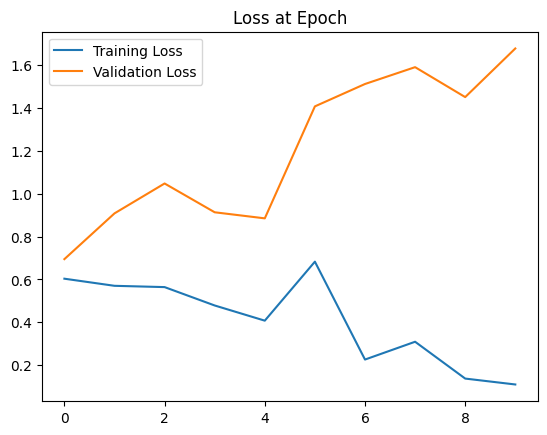

In [ ]:
train_loss = [tl.item() for tl in train_losses]
plt.plot(train_loss, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

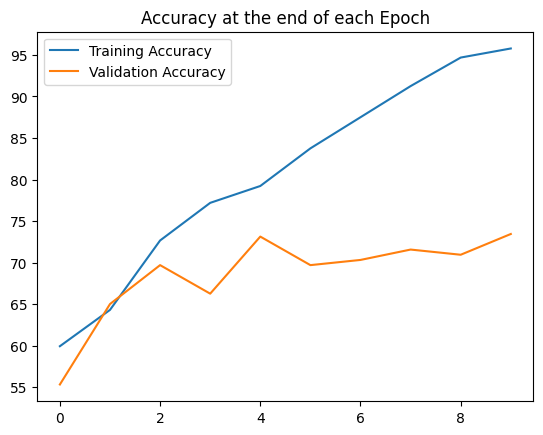

In [ ]:
plt.plot([t/12.8 for t in train_correct], label="Training Accuracy")
plt.plot([t/3.2 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()


In [ ]:
test_load_everything = DataLoader(test_data, batch_size=320, shuffle=False)

In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.round(torch.sigmoid(y_val))
    correct += (predicted.squeeze() == y_test).sum()

In [ ]:
correct.item()/len(test_data)*100

73.4375

In [ ]:
correct

tensor(235)

In [ ]:
test_data.__getitem__(89)[0].shape

torch.Size([3, 128, 128])

In [ ]:
test_data.__getitem__(47)[1]

0

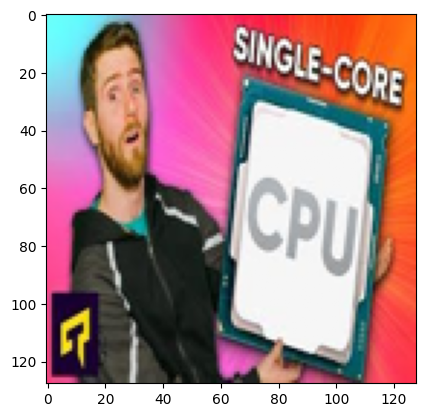

In [ ]:
plt.imshow(np.transpose(test_data.__getitem__(47)[0], (1, 2, 0)))

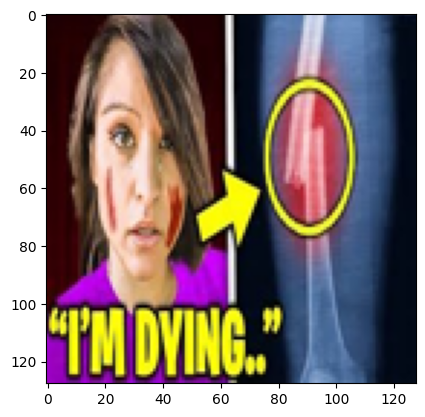

In [ ]:
plt.imshow(np.transpose(train_data.__getitem__(2)[0], (1, 2, 0)))

In [ ]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data.__getitem__(47)[0].view(1,3,128,128))

In [ ]:
torch.round(torch.sigmoid(new_prediction)).squeeze()

tensor(0.)

In [ ]:
torch.save(model.state_dict(), 'thumbnailModel.pt')